### 运动学模型 ###

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

class CarModel:


    L           = 0.1
    d           = 0.04
    theta_max   = 0.7
    v_max       = 0.5
    a_max       = 0.5

    # input 
    a           = 0.0
    theta       = 0.0
    v           = 0.0

    # state
    x           = 0.0
    y           = 0.0
    phi         = 0.0

    def __init__(self):
        pass
    def inputControl(self, v, theta):
        if v > self.v_max:
            v = self.v_max
        elif v < -self.v_max:
            v = self.v_max * -1
        if theta > self.theta_max:
            theta = self.theta_max
        elif theta < -self.theta_max:
            theta = self.theta_max * -1
        self.v = v
        self.theta = theta
    def inputPose(self, x, y, phi):
        self.x = x
        self.y = y
        self.phi = phi
    def update(self, dt):
        temp = -math.tan(self.theta)
        if temp == 0:
            temp = 1e-20
        R = self.L / temp
        # R = abs(R)
        x_dif = self.v * math.cos(self.phi)
        y_dif = self.v * math.sin(self.phi)
        phi_dif = self.v / R * dt
        self.x += x_dif * dt
        self.y += y_dif * dt
        self.phi += phi_dif 
        self.phi = self.phi % (2 * math.pi)
        if self.phi > math.pi:
            self.phi = self.phi - 2 * math.pi
        
        # self.phi = self.phi % (math.pi)

    def getState(self):
        return self.x, self.y, self.phi
    
    def get_velocity(self):
        return self.v
    
    def reset(self):
        self.x = 0.0
        self.y = 0.0
        self.phi = 0.0
        self.v = 0.0
        self.theta = 0.0
        self.a = 0.0
        self.v = 0.0
        self.theta = 0.0


### 模糊控制 ###

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

class FuzzySystem:
    def __init__(self):
        # goal 
        self.range_goal = [0, 3]
        self.k_goal = 1.5
        self.ms_goal = [0.0, 0.0] # near, far
        # d_phi
        self.range_d_phi = [0, math.pi]
        self.k_d_phi = math.pi / 6
        self.ms_d_phi = [0, 0] # near, far
        # obstacle
        self.range_obstacle = [0, 1]
        self.k_obstacle = 0.6
        self.ms_obstacle = [0, 0] # near, far
        
    def function_sigmod(self, x, k, x_min, x_max, slope = 20):
        x_range = abs(x_max - x_min)
        u_x = (x - x_min) / x_range
        u_k = (k - x_min) / x_range
        a = slope
        value = 1 / (1 + math.exp(-a*(u_x - u_k)))
        return 1 - value, value # near, far

    def fuzzification(self, goal, d_phi, obstacle): 
        ## fuzzification
        # goal
        goal_near, goal_far = self.function_sigmod(goal, self.k_goal, self.range_goal[0], self.range_goal[1])
        self.ms_goal = [goal_near, goal_far]
        print(f'goal:   N: {self.ms_goal[0]:.3f}, F: {self.ms_goal[1]:.3f}')
        # d_phi
        d_phi_near, d_phi_far = self.function_sigmod(d_phi, self.k_d_phi, self.range_d_phi[0], self.range_d_phi[1])
        self.ms_d_phi = [d_phi_near, d_phi_far]
        print(f'd_phi:  N: {self.ms_d_phi[0]:.3f}, F: {self.ms_d_phi[1]:.3f}')
        # obstacle
        obstacle_near, obstacle_far = self.function_sigmod(obstacle, self.k_obstacle, self.range_obstacle[0], self.range_obstacle[1])
        self.ms_obstacle = [obstacle_near, obstacle_far]
        print(f'obs:    N: {self.ms_obstacle[0]:.3f}, F: {self.ms_obstacle[1]:.3f}')
        return self.ms_goal, self.ms_d_phi, self.ms_obstacle

    def rule_base(self, ms_goal, ms_d_phi, ms_obstacle):
        menbership = [
            [ms_goal[0], ms_d_phi[0], ms_obstacle[0]],
            [ms_goal[1], ms_d_phi[1], ms_obstacle[1]],
        ]
        # print(menbership[0])
        N = 0
        F = 1
        rules = [
            [N, F, N,],
            [F, F, N,],
            [N, F, F,],
            [F, F, F,],
            [N, N, N,],
            [F, N, N,],
            [N, N, F,],
            [F, N, F,],
        ]
        # print(rules[0][0])
        # print(menbership[rules[0][0]])
        goal_near, goal_far = ms_goal
        d_phi_near, d_phi_far = ms_d_phi
        obstacle_near, obstacle_far = ms_obstacle
        # print(f'menbership: {menbership[0][0]}')
        R1 = min(menbership[ rules[0][0] ][0], menbership[ rules[0][1] ][1], menbership[ rules[0][2] ][2])
        R2 = min(menbership[ rules[1][0] ][0], menbership[ rules[1][1] ][1], menbership[ rules[1][2] ][2])
        R3 = min(menbership[ rules[2][0] ][0], menbership[ rules[2][1] ][1], menbership[ rules[2][2] ][2])
        R4 = min(menbership[ rules[3][0] ][0], menbership[ rules[3][1] ][1], menbership[ rules[3][2] ][2])
        R5 = min(menbership[ rules[4][0] ][0], menbership[ rules[4][1] ][1], menbership[ rules[4][2] ][2])
        R6 = min(menbership[ rules[5][0] ][0], menbership[ rules[5][1] ][1], menbership[ rules[5][2] ][2])
        R7 = min(menbership[ rules[6][0] ][0], menbership[ rules[6][1] ][1], menbership[ rules[6][2] ][2])
        R8 = min(menbership[ rules[7][0] ][0], menbership[ rules[7][1] ][1], menbership[ rules[7][2] ][2])
        # print(f'R1: {R1}')
        return [R1, R2, R3, R4, R5, R6, R7, R8]

    def defuzzification(self, rules):
        U1 = 0.1
        U2 = 0.1
        U3 = 0.4
        U4 = 0.8
        U5 = 1.0 - U4
        U6 = 1.0 - U3
        U7 = 1.0 - U2
        U8 = 1.0 - U1
        # print(rules[0])
        U_output = U1*rules[0] + U2*rules[1] + U3*rules[2] + U4*rules[3] + U5*rules[4] + U6*rules[5] + U7*rules[6] + U8*rules[7]
        return U_output

    def inference(self, goal, d_phi, obstacle):
        ms_goal, ms_d_phi, ms_obstacle = self.fuzzification(goal, d_phi, obstacle)
        rules = self.rule_base(ms_goal, ms_d_phi, ms_obstacle)
        print(f'R1: {rules[0]:.3f}, R2: {rules[1]:.3f}, R3: {rules[2]:.3f}, R4: {rules[3]:.3f}, R5: {rules[4]:.3f}, R6: {rules[5]:.3f}, R7: {rules[6]:.3f}, R8: {rules[7]:.3f}')
        output = self.defuzzification(rules)
        return output


### Bounded-DWA 规划器 ###

参数：
1. sim_t：          仿真时长
2. v_max：          最大速度
3. v_min：          最小速度
4. a_max：          最大加速度
5. a_min：          最小加速度
6. theta_max：      最大转角
7. theta_min：      最小转角
8. v_sample_num：   速度采样数
9. sim_step_num：   仿真步数

In [22]:
import math
import numpy as np

def cal_angle_of_vect(a, b):
        dot_product = a[0] * b[0] + a[1] * b[1]
        magnitude_a = math.sqrt(a[0] ** 2 + a[1] ** 2)
        magnitude_b = math.sqrt(b[0] ** 2 + b[1] ** 2)
        if magnitude_a == 0 or magnitude_b == 0:
            return 0.0
        cosine_of_angle = dot_product / (magnitude_a * magnitude_b)
        # print(cosine_of_angle)
        angle_rad = math.acos(cosine_of_angle)
        angle_deg = math.degrees(angle_rad)
        return angle_deg

def find_max_and_index(arr):
    max_value = arr[0]
    max_index = 0
    for i in range(len(arr)):
        if arr[i] > max_value:
            max_value = arr[i]
            max_index = i
    return max_value, max_index

def find_min_and_index(arr):
    max_value = arr[0]
    max_index = 0
    for i in range(len(arr)):
        if arr[i] < max_value:
            max_value = arr[i]
            max_index = i
    return max_value, max_index

class BoundedDWA:
    def __init__(self):
        # parameters
        self.L           = 0.1
        self.d           = 0.04
        self.theta_max   = 0.7
        self.v_max       = 0.5
        self.a_max       = 0.5
        self.car = CarModel()
        # input
        self.sim_t           = 0.1
        # sample space boundary
        self.v_max           = 0.5
        self.v_min           = -0.5
        self.a_max           = 0.5
        self.a_min           = -0.5
        self.a_theta_max     = 0.7
        self.a_theta_min     = -0.7
        self.theta_max       = 0.7
        self.theta_min       = -0.7
        # sample space size
        self.sample_axis     = 9
        self.sim_step_num    = 5
        # constraints
        self.fiction_factor  = 0.3
        self.gravity_acc     = 9.8
        # variables

        self.v_window_min = 0.0
        self.v_window_max = 0.0
        self.theta_window_min = 0.0
        self.theta_window_max = 0.0

        self.v_now      = 0.0
        self.theta_now  = 0.0
        self.car_pos    = np.zeros((3, 1))
        self.target_pos = np.zeros((3, 1))
        self.pos_car    = [0,0,0]
        self.car_xy     = [0,0]
        self.car_phi    = 0
        self.pos_goal   = [0,0,0]
        self.goal_xy    = [0,0]
        self.goal_phi   = 0

        self.sample_space = np.zeros((self.sample_axis, self.sample_axis, 3))
        self.trajectory_list    = []
        self.trajectory_num     = 0
        # cost function weight
        self.w_heading   = 1.0
        self.w_dis_obs   = 1.0
        self.w_velocity  = 1.0
        self.w_direction = 1.0
        self.w_dis_vert  = 1.0
        self.cost_list          = []
        self.cost_heading_list  = []
        self.cost_dis_obs_list  = []
        self.cost_velo_list     = []
        self.cost_direction_list= []
        self.cost_dis_vert_list = []
    
    # set and get functions
    def set_sim_t(self, sim_t):
        self.sim_t = sim_t
    def set_sample_axis(self, sample_axis):
        self.sample_axis = sample_axis
        self.sample_space = np.zeros((self.sample_axis, self.sample_axis, 3))
    def set_sim_step_num(self, sim_step_num):
        self.sim_step_num = sim_step_num
    def get_all_trajectory(self):
        return self.trajectory_list
    def get_all_cost(self):
        all_coat = [self.cost_list, self.cost_heading_list, self.cost_dis_obs_list, self.cost_velo_list, self.cost_direction_list, self.cost_dis_vert_list]
        return all_coat
    def selected_trajectory(self):
        pass
    # evaluate the cost of the trajectory
    def update_weight(self, w_heading, w_dis_obs, w_velocity, w_direction, w_dis_vert):
        self.w_heading   = w_heading
        self.w_dis_obs   = w_dis_obs
        self.w_velocity  = w_velocity
        self.w_direction = w_direction
        self.w_dis_vert  = w_dis_vert
        
    def cal_weight(self):
        fs = FuzzySystem()
        d_goal = math.sqrt((self.goal_xy[0] - self.car_xy[0]) ** 2 + (self.goal_xy[1] - self.car_xy[1]) ** 2)
        d_phi = abs(self.car_phi - self.goal_phi)
        # print(f'd_goal: {d_goal}, d_phi: {d_phi}')
        obstacle = 100
        fuzzy_output = fs.inference(d_goal, d_phi, obstacle)
        w_heading   = 1.0
        w_dis_obs   = 1.0
        w_velocity  = 1.0
        w_direction = 1.0
        w_dis_vert  = w_direction * fuzzy_output
        print(f'fuzzy_output: {fuzzy_output}')
        print(f'heading: {w_heading}\ndis_obs: {w_dis_obs}\nvelocity: {w_velocity}\ndirection: {w_direction}\ndis_vert: {w_dis_vert}')
        self.update_weight(w_heading, w_dis_obs, w_velocity, w_direction, w_dis_vert)

    def cost_heading(self):
        temp = 0.0
        temp_list = []
        for i in range(self.trajectory_num):
            x_list, y_list, phi_list, v_samp, theta_samp = self.trajectory_list[i]
            x = x_list[-1]
            y = y_list[-1]
            phi = phi_list[-1]
            if v_samp == 0:
                v_samp = 1e-20
            v_direction = v_samp / abs(v_samp)
            vec_car2goal    = [self.goal_xy[0] - x, self.goal_xy[1] - y]
            vec_car         = [math.cos(phi) * v_direction, math.sin(phi) * v_direction]
            # print(f'{i} \t | self.goal_xy: {self.goal_xy}')
            # print(f'{i} \t | vec_car: {vec_car}, vec_car2goal: {vec_car2goal}')
            angle = cal_angle_of_vect(vec_car, vec_car2goal)
            # print(f'{i} \t | angle: {angle}')
            temp = abs(180.0 - angle) / 180.0
            temp_list.append(temp)
        # print(temp_list)
        # normalization
        max_value, index = find_max_and_index(temp_list)
        # print(max_value)
        np_list = np.array(temp_list)
        np_list = np_list / max_value
        self.cost_heading_list = np_list.tolist()
        return self.cost_heading_list

    def cost_dis_obs(self):
        temp = 0.0
        temp_list = []
        for i in range(self.trajectory_num):
            x_list, y_list, phi_list, v_samp, theta_samp = self.trajectory_list[i]
            self.cost_dis_obs_list.append(temp)
        return self.cost_dis_obs_list

    def cost_velocity(self):
        temp = 0.0
        temp_list = []
        for i in range(self.trajectory_num):
            x_list, y_list, phi_list, v_samp, theta_samp = self.trajectory_list[i]
            if temp >= 0:
                temp = abs(v_samp)
            if temp < 0:
                temp = abs(v_samp) / 2.0
            temp_list.append(temp)
        # print(temp_list)
        # normalization
        max_value, index = find_max_and_index(temp_list)
        np_list = np.array(temp_list)
        np_list = np_list / max_value
        self.cost_velo_list = np_list.tolist()
        return self.cost_velo_list

    def cost_direction(self):
        temp = 0.0
        phi_predicted = 0.0
        temp_list = []
        for i in range(self.trajectory_num):
            x_list, y_list, phi_list, v_samp, theta_samp = self.trajectory_list[i]
            phi_predicted = phi_list[-1]
            phi_goal = self.goal_phi
            temp = 1 - abs(phi_predicted - phi_goal)/math.pi
            temp_list.append(temp)
        # normalization
        max_value, index = find_max_and_index(temp_list)
        np_list = np.array(temp_list)
        np_list = np_list / max_value 
        self.cost_direction_list = np_list.tolist()
        return self.cost_direction_list

    def cal_vect2line(self, x, y, phi):
        x1, y1 = x, y
        x2, y2 = x + math.cos(phi), y + math.sin(phi)
        if x2 - x1 == 0.0:
            k = 100000000000000000.0
        else:
            k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        A = k
        B = -1
        C = b
        return A, B, C

    def cal_distance_vertical(self, pos_predicted):
        pre_x = pos_predicted[0]
        pre_y = pos_predicted[1]
        pre_phi = pos_predicted[2]
        A, B, C = self.cal_vect2line(self.goal_xy[0], self.goal_xy[1], self.goal_phi)
        temp = math.sqrt(A ** 2 + B ** 2)
        if temp == 0.0:
            temp = 1e-20
        dis = abs(A * pre_x + B * pre_y + C) / temp
        return dis

    def cal_all_distance_vertical(self):
        dis_vert_list = []
        for i in range(self.trajectory_num):
            x_list, y_list, phi_list, v_samp, theta_samp = self.trajectory_list[i]
            pre_x = x_list[-1]
            pre_y = y_list[-1]
            pre_phi = phi_list[-1]
            dis_vert = self.cal_distance_vertical([pre_x, pre_y, pre_phi])
            dis_vert_list.append(dis_vert)
        return dis_vert_list

    def cost_dis_vert(self):
        dis_vert_list = self.cal_all_distance_vertical()
        max_dis_vert, index = find_max_and_index(dis_vert_list)
        temp_list = 1 - dis_vert_list / max_dis_vert
        max_value, index = find_max_and_index(temp_list)
        np_list = np.array(temp_list)
        np_list = np_list / max_value 
        self.cost_dis_vert_list = np_list.tolist()
        return self.cost_dis_vert_list
        
    def cost_overall(self):
        temp = 0.0
        temp_list = []
        self.cost_heading()
        self.cost_dis_obs()
        self.cost_velocity()
        self.cost_direction()
        self.cost_dis_vert()
        for i in range(self.trajectory_num):
            temp =  self.cost_heading_list[i]   * self.w_heading +      \
                    self.cost_dis_obs_list[i]   * self.w_dis_obs +      \
                    self.cost_velo_list[i]      * self.w_velocity +     \
                    self.cost_direction_list[i] * self.w_direction +    \
                    self.cost_dis_vert_list[i]  * self.w_dis_vert
            temp_list.append(temp)
        self.cost_list = temp_list
        max_cost, index = find_max_and_index(temp_list)
        return self.cost_list, max_cost, index

    def cal_all_trajectory(self):
        self.trajectory_list.clear()
        for i in range(self.sample_axis):
            for j in range(self.sample_axis):
                if self.sample_space[i, j, 2] == 0:
                    continue
                else:
                    v_samp = self.sample_space[i, j, 0]
                    theta_samp = self.sample_space[i, j, 1]
                    x_list, y_list, phi_list = self.cal_trajectory(v_samp, theta_samp)
                    self.trajectory_list.append((x_list, y_list, phi_list, v_samp, theta_samp))
    
    def cal_trajectory(self, velocity, theta):
        x_list      = []
        y_list      = [] 
        phi_list    = []
        sim_interval = self.sim_t / self.sim_step_num
        self.car.inputControl(velocity, theta)
        self.car.inputPose(self.pos_car[0], self.pos_car[1], self.pos_car[2])
        for k in range(self.sim_step_num):
            self.car.update(sim_interval)
            car_x, car_y, car_phi = self.car.getState()
            x_list.append(car_x)
            y_list.append(car_y)
            phi_list.append(car_phi)
        return x_list, y_list, phi_list

    def get_sample_space(self):
        return self.sample_space

    def cal_sample_space(self, v_now, theta_now):
        self.v_now = v_now
        self.theta_now = theta_now
        # calulate sample space window
        self.v_window_min = self.v_now + self.a_min * self.sim_t
        self.v_window_max = self.v_now + self.a_max * self.sim_t
        self.theta_window_min = self.theta_now + self.a_theta_max * self.sim_t
        self.theta_window_max = self.theta_now + self.a_theta_min * self.sim_t
        # self.theta_window_min = self.theta_max
        # self.theta_window_max = self.theta_min
        # print(self.v_window_min, self.v_window_max, self.theta_window_min, self.theta_window_max)
        # calulate sample intervals
        d_v = (self.v_window_max - self.v_window_min) / (self.sample_axis - 1)
        d_theta = (self.theta_window_max - self.theta_window_min) / (self.sample_axis - 1)
        # print(d_v, d_theta)
        # calulate sample axises
        v_sample_space = np.zeros((1, self.sample_axis))
        theta_sample_space = np.zeros((1, self.sample_axis))
        for i in range(self.sample_axis):
            v_sample_space[0, i] = self.v_window_min + i * d_v
            theta_sample_space[0, i] = self.theta_window_min + i * d_theta
            # print(v_sample_space[0, i], theta_sample_space[0, i])
        # calulate sample points
        for i in range(self.sample_axis):
            for j in range(self.sample_axis):
                self.sample_space[i, j, :] = (v_sample_space[0, i], theta_sample_space[0, j], 1)
    
    def sample_space_constraint(self):
        # 遍历样本空间中的每一个点
        for i in range(self.sample_axis):
            for j in range(self.sample_axis):
                # 获取样本空间中(i, j)位置的v和theta值
                v = self.sample_space[i, j][0]
                theta = self.sample_space[i, j][1]
                if theta == 0.0: 
                    theta = 1e-20
                # overall constraint
                if (v > self.v_max) or (v < self.v_min):
                    self.sample_space[i, j][0] = None
                    self.sample_space[i, j][2] = 0
                if (theta > self.theta_max) or (theta < self.theta_min):
                    self.sample_space[i, j][1] = None
                    self.sample_space[i, j][2] = 0
                if pow(v, 2) > abs(self.fiction_factor * self.gravity_acc * self.L / math.tan(theta)):
                    self.sample_space[i, j][0] = None
                    self.sample_space[i, j][2] = 0
    # plan function
    def plan(self, vol_now, theta_now, pos_car, pos_goal):
        self.pos_car = pos_car
        self.pos_goal = pos_goal
        self.car_xy = [pos_car[0], pos_car[1]]
        self.car_phi= pos_car[2]
        self.goal_xy = [pos_goal[0], pos_goal[1]]
        self.goal_phi = pos_goal[2]
        self.cal_sample_space(vol_now, theta_now)
        self.sample_space_constraint()
        self.cal_all_trajectory()
        self.trajectory_num = len(self.trajectory_list)
        self.cal_weight()
        return self.trajectory_list


### 测试速度空间采样 ###

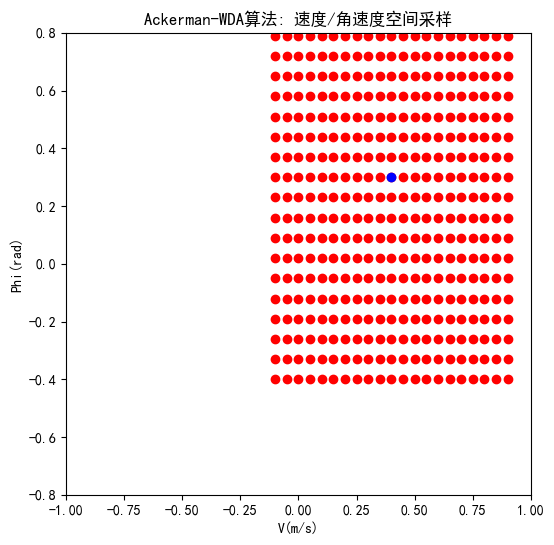

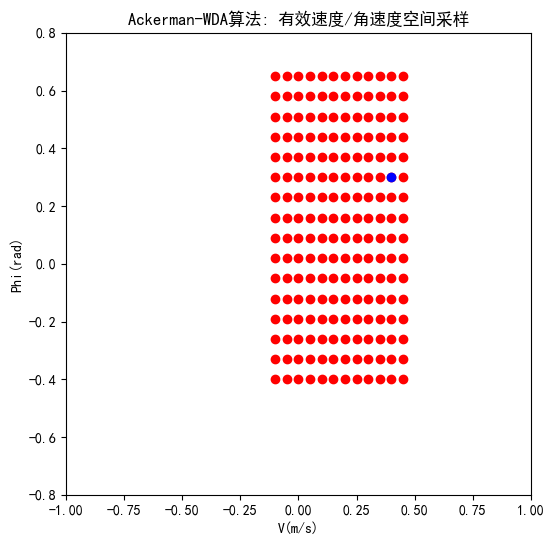

In [25]:
BoundedDWA_test = BoundedDWA()
BoundedDWA_test.set_sim_t(1.0)
BoundedDWA_test.set_sim_step_num(15)
BoundedDWA_test.set_sample_axis(21)
car_v = 0.4
car_theta = 0.3
car_pos = (0, 0.0, 1.57)
target_pos = (0.0, 0.5, 0)
BoundedDWA_test.cal_sample_space(car_v, car_theta)
# BoundedDWA_test.sample_space_constraint()
test_space = BoundedDWA_test.get_sample_space()
# print(test_space)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
plt.plot(test_space[:, :, 0], test_space[:,:, 1], 'ro')
plt.plot(car_v, car_theta, 'bo')
plt.title('Ackerman-WDA算法: 速度/角速度空间采样')
plt.xlabel('V(m/s)')
plt.ylabel('Phi(rad)')
plt.xlim(-1.0, 1.0)
plt.ylim(-0.8, 0.8)
plt.show()

BoundedDWA_test.sample_space_constraint()
test_space = BoundedDWA_test.get_sample_space()
# print(test_space)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.plot(test_space[:, :, 0], test_space[:,:, 1], 'ro')
plt.plot(car_v, car_theta, 'bo')
plt.xlim(-1.0, 1.0)
plt.ylim(-0.8, 0.8)
plt.title('Ackerman-WDA算法: 有效速度/角速度空间采样')
plt.xlabel('V(m/s)')
plt.ylabel('Phi(rad)')
plt.show()

### 测试轨迹生成 ###

angle: 0.0
goal:   N: 0.958, F: 0.042
d_phi:  N: 0.966, F: 0.034
obs:    N: 0.000, F: 1.000
R1: 0.000, R2: 0.000, R3: 0.034, R4: 0.034, R5: 0.000, R6: 0.000, R7: 0.958, R8: 0.042
fuzzy_output: 0.9413342347994534
heading: 1.0
dis_obs: 1.0
velocity: 1.0
direction: 1.0
dis_vert: 0.9413342347994534
time cost 0.009439706802368164 s
180
ctrl_v: 0.4857142857142857 , ctrl_theta: -0.09999999999999998
3.388282000954399
173


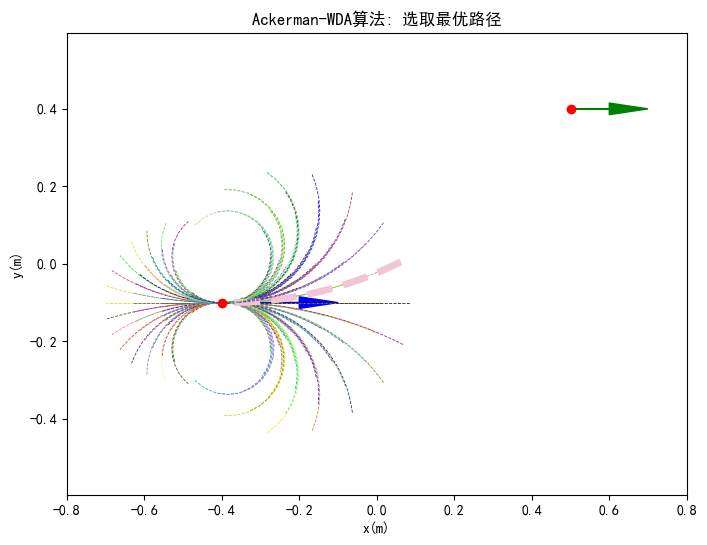

In [35]:
import random
import time
import math
time_start = time.time()
BoundedDWA_test = BoundedDWA()
BoundedDWA_test.set_sim_t(1.0)
BoundedDWA_test.set_sim_step_num(15)
BoundedDWA_test.set_sample_axis(15)
car_v = 0.2
car_theta = 0.0
angle = 0
print(f'angle: {math.radians(angle)}')
car_pos = (-0.4, -0.1, math.radians(0))
target_pos = (0.5, 0.4, math.radians(angle))
plan_test = BoundedDWA_test.plan(car_v, car_theta, car_pos, target_pos)
# def update_weight(self, w_heading, w_dis_obs, w_dis_vert, w_velo, w_direction):
# BoundedDWA_test.update_weight(1.0, 1.0, 1.0, 1.0, 1.0)
cost_list, max_cost, max_idx = BoundedDWA_test.cost_overall()
max_val, max_idx = find_max_and_index(cost_list)

time_end = time.time()
print('time cost', time_end - time_start, 's')
print(len(cost_list))
print(f"ctrl_v: {plan_test[max_idx][3]} , ctrl_theta: {plan_test[max_idx][4]}")
# print(all_cost)
print(max(cost_list))
print(max_idx)
plt.figure(figsize=(8,6))
linestyles = ['--']
# print(len(plan_test))
for i in range(len(plan_test)):
    if i == max_idx:
        linewidth = 5
    else:
        linewidth = 0.6
    # print(plan_test[i][0], plan_test[i][1], plan_test[i][2])
    color = (np.random.rand(), np.random.rand(), np.random.rand())
    linestyle = random.choice(linestyles)
    plt.axis('equal')
    plt.plot(plan_test[i][0], plan_test[i][1], color=color, linestyle=linestyle, linewidth=linewidth)
    plt.xlabel('x')
    plt.ylabel('y')
x_start = target_pos[0]
y_start = target_pos[1]
angle = target_pos[2]
x_delta = 0.1 * math.cos(angle)
y_delat = 0.1 * math.sin(angle)
plt.plot(x_start, y_start, 'ro')
plt.arrow(x_start, y_start, x_delta, y_delat, head_width=0.03, head_length=0.1, fc='green', ec='green')
x_start = car_pos[0]
y_start = car_pos[1]
angle = car_pos[2]
x_delta = 0.2 * math.cos(angle)
y_delat = 0.2 * math.sin(angle)
plt.plot(x_start, y_start, 'ro')
plt.arrow(x_start, y_start, x_delta, y_delat, head_width=0.03, head_length=0.1, fc='blue', ec='blue')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
plt.title('Ackerman-WDA算法: 选取最优路径')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.xlim(-0.8, 0.8)
plt.ylim(-0.6, 0.6)
# BoundedDWA_test.cost_heading()
plt.show()
# print(plan_test[72])

#### 辅助函数：计算两个向量的夹角 ####

In [ ]:
def cal_angle_of_vect(a, b):
        dot_product = a[0] * b[0] + a[1] * b[1]
        magnitude_a = math.sqrt(a[0] ** 2 + a[1] ** 2)
        magnitude_b = math.sqrt(b[0] ** 2 + b[1] ** 2)
        if magnitude_a == 0 or magnitude_b == 0:
            return 0.0
        cosine_of_angle = dot_product / (magnitude_a * magnitude_b)
        print(cosine_of_angle)
        angle_rad = math.acos(cosine_of_angle)
        angle_deg = math.degrees(angle_rad)
        return angle_deg

print(cal_angle_of_vect((1, 0), (-0.0, -1.0)))

-0.0
90.0


#### 辅助函数：计算点到直线的距离 ####
```python
    def cal_vect2line(self, x, y, phi):
        x1, y1 = x, y
        x2, y2 = x + math.cos(phi), y + math.sin(phi)
        if x2 - x1 == 0.0:
            k = 100000000000000000.0
        else:
            k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        A = k
        B = -1
        C = b
        return A, B, C
    def cal_distance_vertical(self, pos_predicted):
        pre_x = pos_predicted[0]
        pre_y = pos_predicted[1]
        pre_phi = pos_predicted[2]
        A, B, C = self.cal_vect2line(self.gaol_xy[0], self.goal_xy[1], self.goal_phi)
        dis = abs(A * pre_x + B * pre_y + C) / math.sqrt(A ** 2 + B ** 2)
        return dis
```

In [ ]:
import math
def cal_vect2line(x, y, phi):
    x1, y1 = x, y
    x2, y2 = x + math.cos(phi), y + math.sin(phi)
    if x2 - x1 == 0.0:
        k = 1000000000000000000000000.0
    else:
        k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    A = k
    B = -1
    C = b
    return A, B, C
def cal_distance_vertical(pos_goal, pos_predicted):
    goal_x = pos_goal[0]
    goal_y = pos_goal[1]
    goal_theta = pos_goal[2]
    pre_x = pos_predicted[0]
    pre_y = pos_predicted[1]
    pre_phi = pos_predicted[2]
    A, B, C = cal_vect2line(goal_x, goal_y, goal_theta)
    dis = abs(A * pre_x + B * pre_y + C) / math.sqrt(A ** 2 + B ** 2)
    return dis
pos_goal = (0.0, math.sqrt(3), math.radians(30))
pos_predicted = (1.0, 0.0, 0.0)
print(cal_distance_vertical(pos_goal, pos_predicted))


2.0
